# Assignment 2: Language Modelling (TA: Yash Patel)

The goal of this assignment is to model city names using character-level language models.

Please make a copy of this notebook (locally or on Colab). Ensure you adhere to the guidelines and submission instructions (mentioned below) for attempting and submitting the assignment.

Given that the class has 150+ students, we will **NOT** entertain any requests for changing your notebooks after the submission deadline (especially in cases when the notebook fails to compile or run because you did not follow the instructions).

### Guidelines for Attempting the Assignment

1. Write your logic in the cells **ONLY** which have the comment `# ADD YOUR CODE HERE`, between the `# BEGIN CODE` and `# END CODE` comments. These cells are also demarcated by the special start (`## ==== BEGIN EVALUATION PORTION`) and end (`## ==== END EVALUATION PORTION`) comments. Do **NOT** remove any of these comments from the designated cells, otherwise your assignment will not be evaluated correctly.

2. Write your code **ONLY** in the cells designated for auto-evaluation, between the `# BEGIN CODE` and `# END CODE` comments. Please don't write any extra code or comments anywhere else.

3. All imports that should be necessary are already provided as part of the notebook. You should **NOT** import any new libraries, otherwise your assignment will not be graded.

4. You need to install the libraries/imports used in this notebook yourself. Its recommended to use python version between 3.9 and 3.11 to attempt this assignment.

5. **If you encounter any errors in the supporting cells during execution, contact the respective TAs.**

6. **Please read the function docs and comments carefully**. They provide specific instructions and examples for implementing each function. Follow these instructions precisely - neither oversimplify nor overcomplicate your implementations. Deviating from the provided implementation guidelines may result in lost marks.

7. **Important**: Use of AI-assistive technologies such as ChatGPT or GitHub CoPilot is not permitted for this assignment. Ensure that all attempts are solely your own. Not following this rule can incur a large penalty, including but not limited to scoring a zero for this assignment.

## Submission Instructions

Note that your assignment will be marked based on the results obtained by functions implemented by you. Do not change the print statements having `EVALUATION` as they are used for auto-evaluation.

You'd need to submit the following files:

  * Save this `.ipynb` to your drive, complete the required code blocks and run the notebook.

  * After completing this assignment, download the notebook as`.py`. Name it as `SAPname_SRno_assignment2.py`, where `SAPname` refers to your name as per SAP record, and `SRno` refers to the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would name it as `Twyla_Linda_15329_assignment2.py`.

  *   The files associated with FNN and RNN models i.e. `model.pt`, `vocab.pt` and `loss.json` will be downloaded and saved in folders with names `fnn` and `rnn` respectively, and these will be contained within folder `SAPname_SRno`. Zip this folder along with the `.py` file, save it as `SAPname_SRno_assignment2` and upload on MS Teams. The directory can be summarised as follows:

```
SAPname_SRno_assignment2
│   SAPname_SRno_assignment2.py  
│
└───SAPname_SRno
│   │
│   └───fnn
│   │   │   model.pt
│   │   │   vocab.pt
│   │   │   loss.json
│   │
│   └───rnn
│       │   model.pt
│       │   vocab.pt
│       │   loss.json

```

Because submissions are auto-graded, please ensure that the naming of the files is consistent with the instructions.

### Marks Distribution

- Unigram: 15
- Bigram: 15
- Trigram: 15
- Neural N-gram LM: 25
- RNN LM: 30

In the cell below, replace `SAPName` with your name as per SAP record, and `SRNo` with the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would use:

```python
STUDENT_SAP_NAME  = "Twyla Linda"
STUDENT_SR_NUMBER = "15329"
```

In [56]:
STUDENT_SAP_NAME  = "Abhishek Kumawat"
STUDENT_SR_NUMBER = "24401"

# Read and Preprocess Data

In [57]:
pip install torch==2.3.0 torchtext==0.18

Note: you may need to restart the kernel to use updated packages.


In [58]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

Please note that we may change the contents of the following four files when we rerun your code, so please make sure that your solution is not specifically engineered to just these names.

In [59]:
# Download the training and validation datasets
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8/export?format=csv"
!wget -O valid_data.csv "https://docs.google.com/spreadsheets/d/1cxkItpdzz0yWc4Tk_1oA4UO6_oUy2cyF4mW3R1D9G9k/export?format=csv"

# Download the text for evaluation
!wget -O eval_prefixes.txt "https://drive.google.com/uc?export=download&id=1tuRLJXLd2VcDaWENr8JTZMcjFlwyRo60"
!wget -O eval_sequences.txt "https://drive.google.com/uc?export=download&id=1kjPAR04UTKmdtV-FJ9SmDlotkt-IKM3b"

--2025-03-19 17:42:01--  https://docs.google.com/spreadsheets/d/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8/export?format=csv
Resolving docs.google.com (docs.google.com)... 142.250.195.174
Connecting to docs.google.com (docs.google.com)|142.250.195.174|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-14-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/0bpu3l305rutcu4am0qmgt3hkc/1742386335000/118234330873002746631/*/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8?format=csv [following]
--2025-03-19 17:42:01--  https://doc-00-14-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/0bpu3l305rutcu4am0qmgt3hkc/1742386335000/118234330873002746631/*/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8?format=csv
Resolving doc-00-14-sheets.googleusercontent.com (doc-00-14-sheets.googleusercontent.com)... 142.251.220.1
Connecting to doc-00-14-sheets.googleusercontent.com (doc-00-14-sheets.googleusercontent.com)|142.251.220.

In [60]:
## Please do not change anything in this code block.

def read_dataframe(ds_type):
    """
    Args:
        ds_type [str] :  dataset type (train or valid)

    Returns:
        df [pandas dataframe]
    """

    df = pd.read_csv(f"/content/{ds_type}_data.csv", header=0)
    print(df)
    df = df[~df['Name'].isna()]
    df['Name'] = df['Name'].astype(str)
    return df

# Load the training and validation datasets
train_data = read_dataframe("train")
validation_data = read_dataframe("valid")

# Read files containing prefixes and character sequences for evaluation
with open('eval_prefixes.txt', 'r') as file:
    eval_prefixes = []
    for line in file:
        eval_prefixes.append(line.strip().split(" "))

with open('eval_sequences.txt', 'r') as file:
    eval_sequences = []
    for line in file:
        eval_sequences.append(line.strip().split(" "))

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

                Name
0             susari
1             belari
2            bandora
3       tummalapenta
4          majhgawan
...              ...
3395     parappukara
3396      morubagalu
3397          dasaut
3398  pullalacheruvu
3399         bhavani

[3400 rows x 1 columns]
            Name
0      enamadala
1     aurangabad
2     mustafabad
3         kalyan
4        kadiyam
...          ...
1129  madhavaram
1130     shahpur
1131     bimawan
1132     jalgaon
1133   virapandi

[1134 rows x 1 columns]
Length of training data: 3400
Length of validation data: 1134


In [61]:
## Please do not change anything in this code block.

START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens
vocab_from_ascii = False

def build_vocab(names):
    """
    Builds a vocabulary given a list of names

    Args:
        names [list[str]]: list of names

    Returns:
        vocab [torchtext.vocab]: vocabulary based on the names

    """

    if vocab_from_ascii:
        char_counts = {chr(i):i for i in range(128)}
    else:
        char_counts = Counter("".join(names))

    vocab = build_vocab_from_iterator(
                    char_counts,
                    specials=[UNK, START, END], #adding special tokens to the vocabulary
                    min_freq=1
                )
    vocab.set_default_index(vocab[UNK])
    return vocab


def tokenize_name(name):
    """
    Tokenise the name i.e. break a name into list of characters

    Args:
        name [str]: name to be tokenized

    Returns:
        list of characters
    """

    return list(str(name))


def process_data_for_input(data_iter, vocab):
    """
    Processes data for input: Breaks names into characters,
    converts out of vocabulary tokens to UNK and
    appends END token at the end of every name

    Args:
        data_iter: data iterator consisting of names
        vocab: vocabulary

    Returns:
        data_iter [list[list[str]]]: list of names, where each name is a
                                list of characters and is appended with
                                START and END tokens

    """

    vocab_set = set(vocab.get_itos())
    # convert Out Of Vocabulary (OOV) tokens to UNK tokens
    data_iter = [[char if char in vocab_set else UNK
                        for char in tokenize_name(name)] for name in data_iter]
    data_iter = [[START] + name + [END] for name in data_iter]
    return data_iter


def get_tokenised_text_and_vocab(ds_type, vocab=None):
    """
    Reads input data, tokenizes it, builds vocabulary (if unspecified)
    and outputs tokenised list of names (which in turn is a list of characters)

    Args:
        ds_type [str]: Type of the dataset (e.g., train, validation, test)
        vocab [torchtext.vocab]: vocabulary;
                                 If vocab is None, the function will
                                 build the vocabulary from input text.
                                 If vocab is provided, it will tokenize name
                                 according to the vocab, replacing any tokens
                                 not part of the vocab with UNK token.

    Returns:
        data_iter: data iterator for tokenized names
        vocab: vocabulary
    """

    # read the 'Name' column of the dataframe
    if ds_type=='train':
        data_iter = train_data['Name']
    elif ds_type=='valid':
        data_iter = validation_data['Name']
    else:
        data_iter = test_data['Name']

    # build vocab from input data, if vocab is unspecified
    if vocab is None:
        vocab = build_vocab(data_iter)

    # convert OOV chars to UNK, append START and END token to each name
    data_iter = process_data_for_input(data_iter, vocab)

    return data_iter, vocab

Let's look at some examples from the training set

In [62]:
# Look at some random examples from the training set
examples = ", ".join(random.sample(list(train_data['Name']), 5))
f"Examples from the training set: {examples}"

'Examples from the training set: ahmadabad, haridwar, chicholi, savalgi, mehdauli'

# Module 1: N-gram Language Modelling

In [63]:
# ==== BEGIN EVALUATION PORTION

"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# ADD YOUR CODE HERE
# BEGIN CODE : stat.namelength

MAX_NAME_LENGTH = 6 # maximum length of names for generation

# END CODE
# ==== END EVALUATION PORTION

In [64]:
# Get data iterator and build vocabulary from input text

train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)
print(train_text)

29
[['<s>', 's', 'u', 's', 'a', 'r', 'i', '</s>'], ['<s>', 'b', 'e', 'l', 'a', 'r', 'i', '</s>'], ['<s>', 'b', 'a', 'n', 'd', 'o', 'r', 'a', '</s>'], ['<s>', 't', 'u', 'm', 'm', 'a', 'l', 'a', 'p', 'e', 'n', 't', 'a', '</s>'], ['<s>', 'm', 'a', 'j', 'h', 'g', 'a', 'w', 'a', 'n', '</s>'], ['<s>', 'k', 'a', 'p', 'a', 's', 'i', 'a', 'w', 'a', 'n', '</s>'], ['<s>', 'g', 'u', 'l', 'b', 'a', 'r', 'g', 'a', '</s>'], ['<s>', 't', 'a', 'u', 'l', 'a', 'h', 'a', '</s>'], ['<s>', 'k', 'i', 'r', 'a', 'n', 'u', 'r', '</s>'], ['<s>', 'k', 'h', 'o', 'k', 'h', 'a', '</s>'], ['<s>', 'k', 'a', 'l', 'a', 'd', 'g', 'i', '</s>'], ['<s>', 'm', 'a', 'l', 'l', 'a', 's', 'a', 'm', 'u', 'd', 'r', 'a', 'm', '</s>'], ['<s>', 'b', 'a', 'l', 'v', 'a', 'd', 'i', '</s>'], ['<s>', 'b', 'a', 'g', 'a', 'u', 'r', 'a', '</s>'], ['<s>', 'm', 'a', 'd', 'a', 't', 't', 'u', 'k', 'k', 'u', 'l', 'a', 'm', '</s>'], ['<s>', 's', 'i', 'l', 'a', 'd', 'o', 'n', '</s>'], ['<s>', 'c', 'h', 'a', 'r', 'i', 'p', 'a', 'r', 'a', '</s>'], ['

In [65]:
print(vocab.get_itos())

['<unk>', '<s>', '</s>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Now it's time to implement an [n-gram language model](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

One edge case you will need to handle is that you don't have $n-1$ prior characters at the beginning of the text.  One way to do this is by appending the `START` token $n-1$ times at the start of the name, when implementing an $n$-gram model. You may choose whichever method you like to handle this case as long as you produce a valid probability distribution (one that sums to one).

**Generating names**

To generate from a language model, we can sample one char at a time conditioning on the chars we have generated so far.

In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k chars or sharpening the distribution with a temperature.  You can read more about sampling from a language model in [this](https://arxiv.org/pdf/1904.09751.pdf) paper.


We will now implement N-gram models with $N=1$ (unigram), $N=2$ (bigram), and $N=3$ (trigram).

**Utility Functions**

Implement the utility functions `get_unigram_counts`, `get_bigram_counts` and `get_trigram_counts`. You can use these functions while implementing n-gram models.

In [66]:
# ==== BEGIN EVALUATION PORTION
def get_unigram_counts(corpus):
    """
    Given a corpus, calculates the unigram counts for each character in the corpus

    Args:
        corpus [list[list[str]]]: list of tokenized characters. Text is appended with END token.

    Returns:
        unigram_counts [dict [key: char, value: count]]:
            dictionary of unigram counts for each character in the corpus
        Example:
        > unigram_counts["c1"] = 5
    """

    # ADD YOUR CODE HERE
    # BEGIN CODE : unigram_count.get_unigram_counts
    unigram_counts = defaultdict(int)
    for names in corpus:
            for char in names:
                unigram_counts[char] += 1
    # END CODE

    return unigram_counts
    

# ==== END EVALUATION PORTION

In [67]:
# ==== BEGIN EVALUATION PORTION
def get_bigram_counts(corpus):
    """
    Given a corpus, calculates the bigram counts for each bigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case whhere beginning of the name
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        bigram_counts [dict[dict]]:
            nested dictionary of bigram counts for each bigram in the corpus
        Example:
        > bigram_counts["c1"]["c2"] = 5
        here bigram_counts["c1"]["c2"] represents P("c2"|"c1")
        P["c1"]["c2"] means P[char_i = "c2"|char_{i-1} = "c1"]
    """

    # ADD YOUR CODE HERE
    # BEGIN CODE : bigram_counts.get_bigram_counts
    bigram_counts = defaultdict(lambda : defaultdict(int))
    for name in corpus:
        for char in range(1, len(name)):
            bigram_counts[name[char-1]][name[char]] += 1

    # END CODE

    return bigram_counts
    

# ==== END EVALUATION PORTION

In [68]:
# ==== BEGIN EVALUATION PORTION
def get_trigram_counts(corpus):
    """
    Given a corpus, calculates the trigram counts for each trigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case where beginning of the text
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        trigram_counts [dict[dict[dict]]]:
            nested dictionary for each trigram in the corpus
        Example:
        > trigram_counts["c1"]["c2"]["c3"] = 5
        P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]

    """

    # ADD YOUR CODE HERE
    # BEGIN CODE : trigram_counts.get_trigram_counts
    trigram_counts = defaultdict(lambda :defaultdict(lambda :defaultdict(int)))
    for name in corpus:
        for i in range(2, len(name)):
            trigram_counts[name[i-2]][name[i-1]][name[i]] += 1

    # END CODE

    return trigram_counts

# ==== END EVALUATION PORTION

In [69]:
"""
Implementation of the n-gram language models.
All other n-gram models (unigram, bigram, etc.) would follow the same skeleton.
"""

class NGramLanguageModel(object):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            -
        """
        return

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["c1"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
                for N=3 (trigram); dict[dict[dict]]
                    > P["c1"]["c2"]["c3"] = 0.0001
                    P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]
        """

        return


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the language model

        Args:
            name [list]: list of tokens

        Returns:
            log_prob [float]: Log probability of the given name
        """
        return 0.0


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity [float]: perplexity of the given text
        """
        return 0.0


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.
        You may stop the generation when n tokens have been generated,
        or when you encounter the END token.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            names [list[str]]: list of generated names
        """
        return []

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        return []

    def get_position_specific_probabilities(self, max_position=5):
        """
        Compute character probability distributions for each position in names.

        This function provides methods to compute position specific character probability distributions based on unigram,
        bigram, and trigram models.

        The following probability distributions are implemented:
        - **Unigram Model**: P(char | position) → Probability of a character appearing at a given position.
        - **Bigram Model**: P(current_char | prev_char) → Probability of a character given the previous one.
        - **Trigram Model**: P(current_char | prev_char1, prev_char2) → Probability of a character given the last two.

        **Key Functions:** For specific details and examples, refer to the respective functions in each model class for Unigram, Bigram and Trigram.
        - `get_position_specific_probabilities()`: Computes probability distributions.
          - **Unigram**: P(char | position) → See `UnigramModel.get_position_specific_probabilities()`
          - **Bigram**: P(current_char | prev_char) → See `BigramModel.get_position_specific_probabilities()`
          - **Trigram**: P(current_char | prev_char1, prev_char2) → See `TrigramModel.get_position_specific_probabilities()`

        """

        return []

In [70]:
# ## Please do not change anything in this code block.

def check_validity(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1 or is_neural:
        P = model.get_next_char_probabilities()
        is_valid = validate_probability_distribution(P.values())
        if not is_valid:
            return is_valid

    elif ngram==2:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():

            is_valid = validate_probability_distribution(list(P[char1].values()))
            if not is_valid:
                return is_valid

    elif ngram==3:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            for char2 in P[char1].keys():
                is_valid = validate_probability_distribution(list(P[char1][char2].values()))
                if not is_valid:
                    return is_valid
    else:
        print("Enter a valid number for ngram")

    return True


def validate_probability_distribution(probs):
    """
    Checks if probs is a valid probability distribution
    """
    

    if not min(probs) >= 0: 
        print("Negative value in probabilities")
        return False
    elif not max(probs) <= 1 + 1e-8:
        print("Value larger than 1 in probabilities")
        return False
    elif not abs(sum(probs)-1) < 1e-4:
        print("probabilities do not sum to 1")
        return False
    return True

def check_validity_of_position_specific_probability(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1:
        position_distributions = model.get_position_specific_probabilities()
        valid_count = 0
        total_positions = len(position_distributions)

        for pos, char_probs in enumerate(position_distributions, start=1):
            total_prob = sum(char_probs.values())
            if 0.99 <= total_prob <= 1.01:
                valid_count += 1
        return valid_count

    elif ngram==2 or ngram==3:
        position_distributions = model.get_position_specific_probabilities()
        valid_count = 0
        total_positions = len(position_distributions)
        for pos, dist in enumerate(position_distributions, start=1):
            if not dist:
                print(f"Validation Failed at Position {pos}! No distributions found.")
                continue
            position_valid = True
            for prev_char, next_char_probs in dist.items():
                total_prob = sum(next_char_probs.values())
                if not (0.99 <= total_prob <= 1.01):
                    position_valid = False
            if position_valid:
                valid_count += 1
        return valid_count

    else:
        print("Enter a valid number for ngram")

    return True

def eval_ngram_model(model, n, ngram, ds, ds_name, eval_prefixes, eval_sequences, num_names=5, is_neural=False):
    """
    Runs evaluations on n-gram models with beam search support
    """
    # (1) Check probability distribution validity
    is_valid = check_validity(model=model, ngram=ngram, is_neural=is_neural)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) Check position specific probability distribution validity
    if not is_neural:
        valid_count = check_validity_of_position_specific_probability(model=model, ngram=ngram, is_neural=is_neural)
        print(f'Total positions which have valid probability distributions: {valid_count}')

    # (3) Evaluate perplexity
    print(f'EVALUATION of {ngram}-gram on {ds_name} perplexity:',
          model.get_perplexity(ds))

    # (4) Generate top-k names using beam search
    generated_names = ", ".join(model.generate_names(n=n,k=num_names))
    print(f'EVALUATION {ngram}-gram TOP {num_names} names: {generated_names}')

    # (5) Generate names with prefixes
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(n=n, k=num_names, prefix=prefix))
        prefix_str = ''.join(prefix)
        print(f'EVALUATION {ngram}-gram TOP {num_names} names with prefix "{prefix_str}": {generated_names_with_prefix}')

    # (6) Get most likely characters
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence_str = "".join(sequence)
        print(f"EVALUATION {ngram}-gram top likely chars after '{sequence_str}': {most_likely_chars}")

    # (7) Check KL divergence for unigram
    if ngram==1:
        position_distributions = model.get_position_specific_probabilities(max_position=5)
        position_1_dist = position_distributions[0]
        position_2_dist = position_distributions[1]
        kl_div = model.calculate_kl_divergence_between_positions(position_1_dist, position_2_dist)
        print(f'KL Divergence between position 1 and 2 is: {kl_div:.3f}')



## 1.1 Unigram

In [71]:
# ==== BEGIN EVALUATION PORTION
"""
Implementaion of a Unigram Model without smoothing
"""

class UnigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.init
        self.unigram_counts = defaultdict(int) #set the unigram counts to default dictionary
        self.total_char = 0

        n=1 
        start_tokens = [START] * (n-1)
        end_tokens = [END] * (n-1) 

        for names in train_text:
            names = start_tokens + names + end_tokens
            for char in names:
                self.unigram_counts[char] += 1
                self.total_char += 1 

        for token in [START, END, UNK]:
            if token not in self.unigram_counts:
                self.unigram_counts[token] = 0
      

        # END CODE


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """
        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.get_next_char_prob
        next_char_probabilities = {char: count/self.total_char for char, count in self.unigram_counts.items()}
        
        # END CODE

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.get_name_log_prob
        name_log_probability = 0
        next_char_probabilities = self.get_next_char_probabilities()
        for char in name:
            if char in next_char_probabilities:
                name_log_probability += math.log(next_char_probabilities[char])
            else:
                name_log_probability += math.log(next_char_probabilities[UNK])
        # END CODE

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.get_perplexity
        perplexity = 0
        total_log_prob = 0
        total_length = 0

        for name in text:
            log_prob = self.get_name_log_probability(name)
            total_log_prob += log_prob
            total_length += len(name)
        perplexity = float(math.exp(-total_log_prob / (total_length)))
        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.generate_names
        names = []
        chars = list(self.unigram_counts.keys())
        probabilities = list(self.get_next_char_probabilities().values())
        
        for _ in range(k):
            name = prefix[:] if prefix else []
            while len(name) < n:
                next_char = np.random.choice(chars, p=probabilities)
                name.append(next_char)
            names.append("".join(name))
        generated_names = list(names)

        # END CODE

        return generated_names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.get_most_likely_chars
        sorted_chars = sorted(self.get_next_char_probabilities().items(), key=lambda x: x[1], reverse=True)
        most_likely_chars = [char for char, _ in sorted_chars[:k]]

        # END CODE

        return most_likely_chars


    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes probability distributions for each character in the vocabulary at specific positions in words.

        This method analyzes the training data to calculate the likelihood of each character appearing
        at different positions (1st, 2nd, 3rd, etc.) in words. For example, it determines how often
        'q' appears as the first letter, second letter, and so on.

        Args:
            max_position (int, optional): Maximum number of initial positions in words to analyze.
                For example, if max_position=3, only the first three positions in words will be
                considered. Defaults to 5.

        Returns:
            list[dict]: A list of dictionaries where:
                - The index represents the position (0-based)
                - Each dictionary maps characters to their probabilities at that position
                - Example: [{'a': 0.1, 'b': 0.2, ...}, {'a': 0.15, 'b': 0.1, ...}, ...]
                - The probabilities in each dictionary sum to 1.0

        Example:
            >>> model.get_position_specific_probabilities(2)
            [
                {'a': 0.12, 'b': 0.08, 'c': 0.15, ...},  # Probabilities for first position
                {'a': 0.40, 'b': 0.11, 'c': 0.07, ...}   # Probabilities for second position
            ]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.get_position_specific_prob
        position_counts = [Counter() for _ in range(max_position)]
        total_counts = [0] * max_position

        # Count occurrences of each character at each position
        for name in train_text:
            for i, char in enumerate(name[1:max_position+1]):
                position_counts[i][char] += 1
                total_counts[i] += 1

        # Compute probabilities for each position
        position_probs = []
        for i in range(max_position):
            probs = {char: count / total_counts[i] for char, count in position_counts[i].items()}
            position_probs.append(probs)

        # Ensure all probability distributions have the same keys
        all_chars = set().union(*[probs.keys() for probs in position_probs])

        # Add missing characters with probability 0
        for probs in position_probs:
            for char in all_chars:
                probs.setdefault(char, 0)  

        position_distributions = list(position_probs)


        # END CODE

        return position_distributions


    def calculate_kl_divergence_between_positions(self, p, q):
        """
        Computes overall KL divergence between two probability distributions.

        Args:
            p [dict]: Probability distribution
            q [dict]: Probability distribution

        Returns:
            kl_divergence [float]: KL(p||q). Returns -1 if the KL divergence is undefined.
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : unigrammodel.kl_divergence
        kl_divergence = 0.0
        for char in p:
            if char in q and q[char] > 0:
                kl_divergence += p[char] * math.log(p[char] / q[char])
            else:
                return -1  # Undefined if q has zero probability for a character in p
        kl_div = float(kl_divergence)

        # END CODE

        return kl_div

# ==== END EVALUATION PORTION

### Eval

**Note**: For models without smoothing, you may observe perplexity as `inf` if the validation or test set contains characters not seen in the train set
However, this should not happen for models where you implement smoothing.

In [72]:
## Please do not change anything in this code block.

unigram_model = UnigramModel(train_text)

# Check the perplexity of the unigram model on the train set
print('unigram train perplexity:', unigram_model.get_perplexity(train_text))

unigram train perplexity: 17.371830431823533


In [73]:
## Please do not change anything in this code block.

eval_ngram_model(model=unigram_model, n = MAX_NAME_LENGTH, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 1-gram on validation perplexity: 17.38669842565595
EVALUATION 1-gram TOP 5 names: a<s>pk<s>v, trn<s>l<s>, elauru, aip</s>ma, o</s>lhar
EVALUATION 1-gram TOP 5 names with prefix "<s><s>sh": <s><s>sh</s>i, <s><s>sh<s>t, <s><s>sh</s>a, <s><s>shat, <s><s>shay
EVALUATION 1-gram TOP 5 names with prefix "<s><s>na": <s><s>naia, <s><s>na</s>a, <s><s>naan, <s><s>na<s>h, <s><s>nark
EVALUATION 1-gram TOP 5 names with prefix "<s><s>da": <s><s>daak, <s><s>dagm, <s><s>daaj, <s><s>da<s>u, <s><s>daeo
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ki": <s><s>kieu, <s><s>kilu, <s><s>kidc, <s><s>kia<s>, <s><s>ki<s>n
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ra": <s><s>rari, <s><s>rann, <s><s>ra</s>a, <s><s>rae</s>, <s><s>rada
EVALUATION 1-gram TOP 5 names with prefix "<s><s>de": <s><s>de<s>t, <s><s>deit, <s><s>dect, <s><s>dei<s>, <s><s>deua
EVALUATION 1-gram TOP 5 names w

In [74]:
## Please do not change anything in this code block.
position_distributions = unigram_model.get_position_specific_probabilities(max_position=5)

print("Position-Specific Probabilities:")
for pos, dist in enumerate(position_distributions, start=1):
    # Sort dictionary by character key (a-z, A-Z)
    sorted_dist = {k: round(v, 2) for k, v in sorted(dist.items())}  # Round to 2 decimal places
    print(f"Position {pos}: {sorted_dist}")

Position-Specific Probabilities:
Position 1: {'a': 0.06, 'b': 0.09, 'c': 0.05, 'd': 0.04, 'e': 0.01, 'f': 0.0, 'g': 0.04, 'h': 0.03, 'i': 0.01, 'j': 0.03, 'k': 0.15, 'l': 0.01, 'm': 0.09, 'n': 0.05, 'o': 0.01, 'p': 0.1, 'q': 0.0, 'r': 0.04, 's': 0.09, 't': 0.05, 'u': 0.01, 'v': 0.04, 'w': 0.0, 'x': 0, 'y': 0.01, 'z': 0.0}
Position 2: {'a': 0.43, 'b': 0.0, 'c': 0.0, 'd': 0.01, 'e': 0.08, 'f': 0, 'g': 0.0, 'h': 0.12, 'i': 0.09, 'j': 0.0, 'k': 0.0, 'l': 0.01, 'm': 0.01, 'n': 0.01, 'o': 0.08, 'p': 0.0, 'q': 0, 'r': 0.02, 's': 0.01, 't': 0.01, 'u': 0.1, 'v': 0.0, 'w': 0.0, 'x': 0, 'y': 0.0, 'z': 0.0}
Position 3: {'a': 0.1, 'b': 0.01, 'c': 0.01, 'd': 0.07, 'e': 0.01, 'f': 0.0, 'g': 0.02, 'h': 0.03, 'i': 0.06, 'j': 0.01, 'k': 0.03, 'l': 0.11, 'm': 0.05, 'n': 0.13, 'o': 0.01, 'p': 0.01, 'q': 0.0, 'r': 0.14, 's': 0.03, 't': 0.07, 'u': 0.02, 'v': 0.01, 'w': 0.01, 'x': 0.0, 'y': 0.01, 'z': 0.01}
Position 4: {'a': 0.25, 'b': 0.02, 'c': 0.01, 'd': 0.05, 'e': 0.02, 'f': 0.0, 'g': 0.05, 'h': 0.07, 'i

position 1: {'s': 0.08823529411764706, 'b': 0.09294117647058824, 't': 0.05, 'm': 0.09117647058823529, 'k': 0.14588235294117646, 'g': 0.03735294117647059, 'c': 0.04617647058823529, 'v': 0.04176470588235294, 'e': 0.013823529411764707, 'a': 0.05941176470588235, 'p': 0.09941176470588235, 'd': 0.036470588235294116, 'r': 0.04029411764705882, 'u': 0.01088235294117647, 'n': 0.04735294117647059, 'j': 0.02676470588235294, 'l': 0.015, 'z': 0.001176470588235294, 'w': 0.003823529411764706, 'i': 0.010294117647058823, 'o': 0.0058823529411764705, 'h': 0.025294117647058825, 'y': 0.005294117647058823, 'f': 0.004705882352941176, 'q': 0.000588235294117647, 'x': 0}
position 2: {'u': 0.10088235294117646, 'e': 0.07794117647058824, 'a': 0.42676470588235293, 'i': 0.08852941176470588, 'h': 0.11764705882352941, 'r': 0.023529411764705882, 't': 0.008529411764705883, 'o': 0.07852941176470589, 's': 0.0058823529411764705, 'v': 0.002058823529411765, 'd': 0.008529411764705883, 'c': 0.0029411764705882353, 'n': 0.0144117

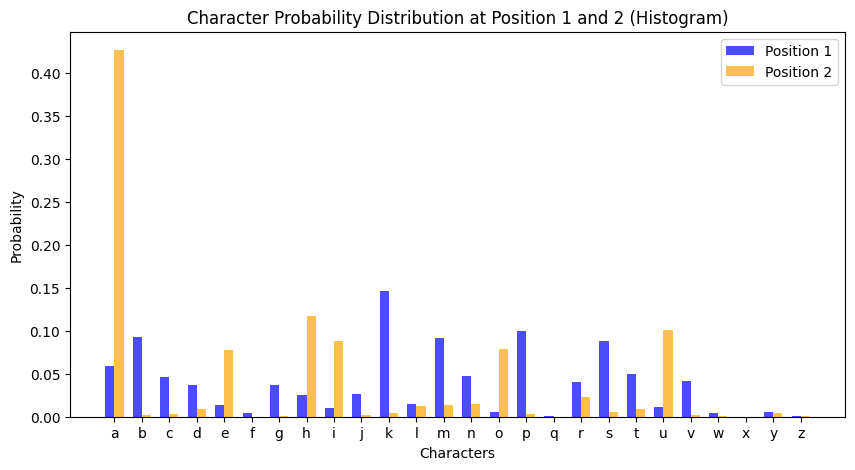

In [75]:
## Please do not change anything in this code block.
import matplotlib.pyplot as plt
import numpy as np

position_1_distribution = position_distributions[0]
position_2_distribution = position_distributions[1]
#debug 
print("position 1:",position_1_distribution)
print("position 2:",position_2_distribution)

sorted_chars = sorted(position_1_distribution.keys())

probs_pos1 = [position_1_distribution[char] for char in sorted_chars]
probs_pos2 = [position_2_distribution[char] for char in sorted_chars]

spacing_factor = 1.5
x = np.arange(len(sorted_chars)) * spacing_factor
width = 0.5

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, probs_pos1, width=width, label="Position 1", color="blue", alpha=0.7)
plt.bar(x + width/2, probs_pos2, width=width, label="Position 2", color="orange", alpha=0.7)
plt.xlabel("Characters")
plt.ylabel("Probability")
plt.title("Character Probability Distribution at Position 1 and 2 (Histogram)")
plt.xticks(ticks=x, labels=sorted_chars)
plt.legend()
plt.show()

### Smoothing

Implement a smoothed version of the unigram model. You may extend the `UnigramModel` class and re-use some of the functions.  For unigram model, you should implement Add-1 smoothing.

You may refer to the lecture slides or [3.5 Smoothing](https://web.stanford.edu/~jurafsky/slp3/3.pdf) for details on different smoothing technqiues.

In [76]:
# ==== BEGIN EVALUATION PORTION
"""
Implementation of unigram model with Add-1 smoothing.

"""
class SmoothedUnigramModel(UnigramModel):

    def __init__(self, train_text):
        super().__init__(train_text)

    '''You should override ONLY those functions which calculate probability of a unigram.
      You can override get_next_char_probabilities or any other helper functions you use in UnigramModel to calculate unigram probabilities.
      Implement Laplace or Add-1 smoothing for the unigram model '''

    # ADD YOUR CODE HERE
    # BEGIN CODE : smoothing.smoothunigram
    def get_next_char_probabilities(self):
        """
        Overrides the method to apply Add-1  smoothing.
        """
        k = 1  # smoothing (Add-1)
        V = len(self.unigram_counts)  # Vocabulary size (number of unique characters)
        
        next_char_probabilities = {
            char: (count + k) / (self.total_char + k * V)
            for char, count in self.unigram_counts.items()
        }
        
        
        return next_char_probabilities



    # END CODE

# ==== END EVALUATION PORTION

In [77]:
## Please do not change anything in this code block.

smoothed_unigram_model = SmoothedUnigramModel(train_text)

# Check the perplexity of the smoothed unigram model on the train set
print('smoothed unigram train perplexity:',
      smoothed_unigram_model.get_perplexity(train_text))

smoothed unigram train perplexity: 17.37249499300166


In [78]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_unigram_model, n = MAX_NAME_LENGTH, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences,  num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 1-gram on validation perplexity: 17.387076245670443
EVALUATION 1-gram TOP 5 names: uvrrra, <s>mda<s></s>, naaasa, ehrgoa, bnna</s><s>
EVALUATION 1-gram TOP 5 names with prefix "<s><s>sh": <s><s>shnk, <s><s>shl<s>, <s><s>shpj, <s><s>shtn, <s><s>sh</s><s>
EVALUATION 1-gram TOP 5 names with prefix "<s><s>na": <s><s>nagt, <s><s>naaa, <s><s>na</s>a, <s><s>na<s>t, <s><s>nai</s>
EVALUATION 1-gram TOP 5 names with prefix "<s><s>da": <s><s>dai<s>, <s><s>daig, <s><s>dark, <s><s>da<s>s, <s><s>dagd
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ki": <s><s>kiae, <s><s>kiye, <s><s>kigh, <s><s>ki</s>d, <s><s>kiwu
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ra": <s><s>raaj, <s><s>rapr, <s><s>rar<s>, <s><s>rau</s>, <s><s>rakm
EVALUATION 1-gram TOP 5 names with prefix "<s><s>de": <s><s>dea<s>, <s><s>dep</s>, <s><s>dea</s>, <s><s>dera, <s><s>detb
EVALUATION 1-gram TOP 5 na

In [79]:
# Release models we don't need any more.
del unigram_model
del smoothed_unigram_model

## 1.2 Bigram


In [80]:
# ==== BEGIN EVALUATION PORTION
"""
Implementation of a Bigram Model.
"""

class BigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.init
        
        self.bigram_counts = defaultdict(lambda : defaultdict(int))  #set the bigram counts to default dictionary
        self.unigram_counts = defaultdict(int) #set the unigram counts to default dictionary
        self.total_char = 0

        n=2
        start_token = [START] * (n-1)
        end_token = [END] * (n-1)

        for names in train_text:
            names = start_token + names + end_token
            for char1,char2 in zip(names[:-1],names[1:]):
                self.bigram_counts[char1][char2] += 1
                self.unigram_counts[char1] += 1
                self.total_char += 1 

        for token in [START, END, UNK]:
            if token not in self.bigram_counts:
                self.bigram_counts[token] = defaultdict(int)

        # END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.get_next_char_prob
        next_char_probabilities = {}

        for char1 in self.bigram_counts:
            total_count = sum(self.bigram_counts[char1].values())
            if total_count > 0:
                next_char_probabilities[char1] = {char2: count / total_count for char2, count in self.bigram_counts[char1].items()}
            else:
                next_char_probabilities[char1] = {}
        
        # Ensure every char1 has some probability distribution
        all_chars = set(self.unigram_counts.keys())
        for char1 in all_chars:
            if char1 not in next_char_probabilities:
                next_char_probabilities[char1] = {}
            if not next_char_probabilities[char1]:
                next_char_probabilities[char1] = {char2: 1 / len(all_chars) for char2 in all_chars}
        
        # Ensure [UNK] token has a valid probability distribution
        if UNK not in next_char_probabilities:
            next_char_probabilities[UNK] = {char2: 1 / len(all_chars) for char2 in all_chars}
        elif not next_char_probabilities[UNK]:
            next_char_probabilities[UNK] = {char2: 1 / len(all_chars) for char2 in all_chars}
            
        # Normalize the probabilities to ensure they sum to 1
        for char1 in next_char_probabilities:
            total_prob = sum(next_char_probabilities[char1].values())
            for char2 in next_char_probabilities[char1]:
                next_char_probabilities[char1][char2] /= total_prob
            
        
        # END CODE
        
        return next_char_probabilities

    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.get_name_log_prob
        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = 0.0

        for char in range(1, len(name)):
            prev_char = name[char-1]
            curr_char = name[char]
            if prev_char in next_char_probabilities and curr_char in next_char_probabilities[prev_char]:
                name_log_probability += math.log(next_char_probabilities[prev_char][curr_char])
            else:
                if UNK in next_char_probabilities and UNK in next_char_probabilities[UNK]:
                    name_log_probability += math.log(next_char_probabilities[UNK][UNK])
                else:
                    name_log_probability += math.log(1e-10)

        # END CODE

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.get_perplexity
        perplexity = 0 
        total_log_prob = 0 
        total_length = 0 
        for name in text:
            log_prob = self.get_name_log_probability(name)
            total_log_prob += log_prob
            total_length += len(name)
        perplexity = float(math.exp(-total_log_prob / (total_length)))


        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.generate_names
        next_char_probabilities = self.get_next_char_probabilities()
        names = []

        for _ in range(k):
            name = prefix[:] if prefix else []
            while len(name) < n:
                prev_char = name[-1] if name else START
                if prev_char in next_char_probabilities:
                    chars, probabilities = zip(*next_char_probabilities[prev_char].items())
                    next_char = np.random.choice(chars, p=probabilities)
                else:
                    next_char = UNK
                if next_char == END:
                    break
                name.append(str(next_char))
            names.append("".join(name))
        # END CODE

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.get_most_likely_chars
        next_char_probabilities = self.get_next_char_probabilities()
        prev_char = sequence[-1] if sequence else START

        if prev_char in next_char_probabilities:
            sorted_chars = sorted(next_char_probabilities[prev_char].items(), key=lambda x: x[1], reverse=True)
            most_likely_chars = [str(char) for char, _ in sorted_chars[:k]]
        else:
            most_likely_chars = [UNK] * k

        # END CODE

        return most_likely_chars

    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes conditional probability distributions P(current_char | prev_char) for each position in words.

        This method analyzes character sequences in the training data to calculate position-specific
        transition probabilities between consecutive characters (bigrams). For each position, it computes
        the probability of seeing a character given the previous character, only including previous characters
        that actually occur at the respective positions in the training data.

        Args:
            max_position (int, optional): Maximum number of positions to analyze, starting from position 1.
                For example, if max_position=3, computes probabilities for positions 1, 2, and 3.
                Defaults to 5.

        Returns:
            list[dict]: A list of nested dictionaries where:
                - Index i contains transitions for position i+1
                - Outer dictionary keys are previous characters that occur at position i
                - Inner dictionary keys are current characters with their conditional probabilities
                - Format: [{prev_char: {current_char: probability}}]
                - All probabilities for a given prev_char sum to 1.0

        Character Handling:
            - All characters in vocabulary including special tokens (<s>, </s>, <UNK>)
            - Only include previous characters that actually occur at the respective positions
            - First position always includes '<s>' as previous character

        Example:
            >>> model.get_position_specific_probabilities(2)
            [
                {
                    '<s>': {'a': 0.3, 'b': 0.1, 'c': 0.2, 'd': 0.05, 'e': 0.1, ...}     # Position 1
                    # Only <s> as it's the only valid previous character for first position
                },
                {
                    'a': {'a': 0.05, 'b': 0.1, 'c': 0.2, 'd': 0.09, 'e': 0.15, 'f': 0.1, ...},      # Position 2
                    'b': {'a': 0.2, 'b': 0.04, 'c': 0.2, 'd': 0.05, 'e': 0.05, 'f': 0.2, ...}, ...
                    # Note: 'x' not included as a previous character key if it never appears at position 1
                }
            ]

        Note:
            - Only include previous characters that actually occur at the respective positions in training data
            - A character 'x' should only be included as a key if it appears at the correct position
              in the training data (e.g., position 1 for predicting position 2)
            - Probabilities are computed from training data frequencies
            - Each inner dictionary should contain probabilities for all possible next characters
            - The sum of probabilities for each valid prev_char should equal 1.0
        """


        # ADD YOUR CODE HERE
        # BEGIN CODE : bigram.get_position_specific_probabilities
        position_counts = [defaultdict(lambda: defaultdict(int)) for _ in range(max_position)]
        total_counts = [defaultdict(int) for _ in range(max_position)]

        # Count occurrences of each character at each position
        for name in train_text:
            for i in range(1, min(len(name), max_position + 1)):
                prev_char = name[i - 1]
                curr_char = name[i]
                position_counts[i - 1][prev_char][curr_char] += 1
                total_counts[i - 1][prev_char] += 1

        # Compute probabilities for each position
        position_distributions = []
        for i in range(max_position):
            probs = {}
            for prev_char, next_char_counts in position_counts[i].items():
                total_count = total_counts[i][prev_char]
                if total_count > 0:
                    probs[prev_char] = {char: count / total_count for char, count in next_char_counts.items()}
            position_distributions.append(probs)

        # END CODE
        return position_distributions

# ==== END EVALUATION PORTION

### Eval

In [81]:
## Please do not change anything in this code block.

bigram_model = BigramModel(train_text)

# check the perplexity of the bigram model on training data
print('bigram train perplexity:', bigram_model.get_perplexity(train_text))

bigram train perplexity: 8.017079234337627


In [82]:
## Please do not change anything in this code block.

eval_ngram_model(model=bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 2-gram on validation perplexity: 8.545011578491875
EVALUATION 2-gram TOP 5 names: <s><s><s>ara, bamama, hnaowa, <s><s><s><s>ev, <s><s><s><s>ga
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s><s>sh, <s><s>sher, <s><s>shot, <s><s>sha, <s><s>shur
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s><s>nava, <s><s>namu, <s><s>nagt, <s><s>naha, <s><s>nata
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s><s>datt, <s><s>dand, <s><s>dari, <s><s>damb, <s><s>dai
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s><s>kitt, <s><s>kiku, <s><s>kikk, <s><s>kima, <s><s>kinu
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s><s>rata, <s><s>rarg, <s><s>raol, <s><s>rata, <s><s>rad
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s><s>dena, <s><s>debu, <s><s>debr, <s><s>deli, <s><s>demb
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s>

In [83]:
## Please do not change anything in this code block. This block is just for your visualization purpose that how your position distributions looks.

position_distributions = bigram_model.get_position_specific_probabilities(max_position=5)
for pos, dist in enumerate(position_distributions, start=1):
    sorted_dist = {
        k: {prev: round(prob, 2) for prev, prob in sorted(v.items())}
        for k, v in sorted(dist.items())
    }

    print(f"Position {pos}: {sorted_dist}")

Position 1: {'<s>': {'a': 0.06, 'b': 0.09, 'c': 0.05, 'd': 0.04, 'e': 0.01, 'f': 0.0, 'g': 0.04, 'h': 0.03, 'i': 0.01, 'j': 0.03, 'k': 0.15, 'l': 0.01, 'm': 0.09, 'n': 0.05, 'o': 0.01, 'p': 0.1, 'q': 0.0, 'r': 0.04, 's': 0.09, 't': 0.05, 'u': 0.01, 'v': 0.04, 'w': 0.0, 'y': 0.01, 'z': 0.0}}
Position 2: {'a': {'b': 0.02, 'c': 0.03, 'd': 0.04, 'g': 0.01, 'h': 0.03, 'i': 0.01, 'j': 0.02, 'k': 0.03, 'l': 0.12, 'm': 0.18, 'n': 0.18, 'p': 0.01, 'r': 0.09, 's': 0.03, 't': 0.06, 'u': 0.01, 'v': 0.03, 'y': 0.04, 'z': 0.01}, 'b': {'a': 0.49, 'e': 0.09, 'h': 0.17, 'i': 0.14, 'o': 0.05, 'r': 0.01, 'u': 0.04, 'y': 0.01}, 'c': {'h': 0.95, 'o': 0.03, 'u': 0.02}, 'd': {'a': 0.24, 'e': 0.19, 'h': 0.31, 'i': 0.1, 'o': 0.05, 'r': 0.02, 'u': 0.1}, 'e': {'d': 0.15, 'k': 0.13, 'l': 0.23, 'm': 0.02, 'n': 0.02, 'r': 0.36, 's': 0.02, 't': 0.06}, 'f': {'a': 0.88, 'r': 0.06, 'y': 0.06}, 'g': {'a': 0.37, 'e': 0.01, 'h': 0.12, 'i': 0.02, 'o': 0.2, 'u': 0.28, 'w': 0.01}, 'h': {'a': 0.56, 'e': 0.07, 'i': 0.13, 'o': 

### Smoothing

Implement a smoothed version of the bigram model. You may extend the `BigramModel` class and re-use some of the functions.

You will implement the following smoothing techniques:
-  Laplace or add-k smoothing
- Interpolation

**Laplace or Add-k smoothing**
- What is the effect of changing `k`?

In [84]:
# ==== BEGIN EVALUATION PORTION

"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : bigramlaplace.val
BIGRAM_LAPLACE_K = 5 # value of k for add-k or Laplace smoothing in bigram models
# END CODE

# ==== END EVALUATION PORTION

In [85]:
# ==== BEGIN EVALUATION PORTION

"""
Implementation of a bigram model with laplace or add-k smoothing.

"""

class LaplaceSmoothedBigramModel(BigramModel):
    # This class extends BigramModel.

    def __init__(self, train_text, k):
        super().__init__(train_text)
        self.k = 1 # specify k for smoothing

    # You should override ONLY those functions which calculate probability of a bigram.
    # You can override get_next_char_probabilities or any other helper functions you use in BigramModel to calculate bigram probabilities.

    # ADD YOUR CODE HERE
    # BEGIN CODE : smoothingbigram.smoothbigram
    def get_next_char_probabilities(self):
        
        next_char_probabilities = {}
        self.vocab_size = len(self.unigram_counts)
        for char1 in self.bigram_counts:
            total_count = sum(self.bigram_counts[char1].values())
            next_char_probabilities[char1] = {char2: (count + self.k) / (total_count + self.k * self.vocab_size) for char2, count in self.bigram_counts[char1].items()}

            # Ensure all characters are included in the probability distribution
            for char2 in range(self.vocab_size):
                if char2 not in next_char_probabilities[char1]:
                    next_char_probabilities[char1][char2] = self.k / (total_count + self.k * self.vocab_size)
            total_prob = sum(next_char_probabilities[char1].values())
            for char2 in next_char_probabilities[char1]:
                next_char_probabilities[char1][char2] /= total_prob
        return next_char_probabilities


    # END CODE

# ==== END EVALUATION PORTION

In [86]:
## Please do not change anything in this code block.

smoothed_bigram_model = LaplaceSmoothedBigramModel(train_text, k=BIGRAM_LAPLACE_K)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 8.16431775046552


In [87]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 2-gram on validation perplexity: 8.69245779262841
EVALUATION 2-gram TOP 5 names: pam, <s>shwal, <s><s><s>r, <s>char, dvabog
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s><s>shen, <s><s>shar, <s><s>shan, <s><s>shai, <s><s>shjh
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s><s>naha, <s><s>naha, <s><s>nawa, <s><s>naik, <s><s>nadu
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s><s>dart, <s><s>dau, <s><s>dapa, <s><s>dasw, <s><s>dall
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s><s>kind, <s><s>kij, <s><s>ki, <s><s>ki, <s><s>kira
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s><s>rade, <s><s>rada, <s><s>rati, <s><s>rala, <s><s>rand
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s><s>ders, <s><s>dena, <s><s>dedu, <s><s>deho, <s><s>delu
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s><s>ni, <s><s>ni, <s>

**Interpolation**
- What are good values for `lambdas` in interpolation?

In [88]:
# ==== BEGIN EVALUATION PORTION

"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# ADD YOUR CODE HERE
# BEGIN CODE : bigramlambdas.val
BIGRAM_LAMBDAS = (0.8, 0.2) # lambdas for interpolation smoothing in bigram models
# END CODE

# ==== END EVALUATION PORTION

In [89]:
# ==== BEGIN EVALUATION PORTION
"""
Implementation of a bigram model with interpolation smoothing
"""

class InterpolationSmoothedBigramModel(BigramModel):

    def __init__(self, train_text, lambdas):
        super().__init__(train_text)
        self.lambda_1, self.lambda_2 = lambdas

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE
    # BEGIN CODE : interpolate.interpolatesmoothing
    def get_next_char_probabilities(self):
        next_char_probabilities = {}
        self.vocab_size = len(self.unigram_counts)
        total_unigram_count = sum(self.unigram_counts.values())

        for char1 in self.bigram_counts:
            total_count = sum(self.bigram_counts[char1].values())
            if total_count > 0:
                next_char_probabilities[char1] = {}
                for char2, count in self.bigram_counts[char1].items():
                    bigram_prob = (count + 1) / (total_count + self.vocab_size)
                    unigram_prob = (self.unigram_counts.get(char2, 0) + 1) / (total_unigram_count + self.vocab_size)
                    next_char_probabilities[char1][char2] = self.lambda_1 * bigram_prob + self.lambda_2 * unigram_prob
            else:
                next_char_probabilities[char1] = {}

        # Ensure every char1 has some probability distribution
        all_chars = set(self.unigram_counts.keys())
        for char1 in all_chars:
            if char1 not in next_char_probabilities:
                next_char_probabilities[char1] = {}
            if not next_char_probabilities[char1]:
                next_char_probabilities[char1] = {}
                for char2 in all_chars:
                    unigram_prob = (self.unigram_counts.get(char2, 0) + 1) / (total_unigram_count + self.vocab_size)
                    next_char_probabilities[char1][char2] = self.lambda_2 * unigram_prob

        # Ensure [UNK] token has a valid probability distribution
        if UNK not in next_char_probabilities:
            next_char_probabilities[UNK] = {char2: 1 / len(all_chars) for char2 in all_chars}
        elif not next_char_probabilities[UNK]:
            next_char_probabilities[UNK] = {char2: 1 / len(all_chars) for char2 in all_chars}

        # Normalize the probabilities to ensure they sum to 1
        for char1 in next_char_probabilities:
            total_prob = sum(next_char_probabilities[char1].values())
            for char2 in next_char_probabilities[char1]:
                next_char_probabilities[char1][char2] /= total_prob

        return next_char_probabilities

    # END CODE

# ==== END EVALUATION PORTION

In [90]:
## Please do not change anything in this code block.

smoothed_bigram_model = InterpolationSmoothedBigramModel(train_text, lambdas=BIGRAM_LAMBDAS)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 8.187814129060442


In [91]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 2-gram on validation perplexity: 8.686870133087265
EVALUATION 2-gram TOP 5 names: <s>odani, <s>kolal, <s><s><s>mar, <s><s>urba, <s>baras
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s><s>sh, <s><s>shik, <s><s>shrr, <s><s>shha, <s><s>shin
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s><s>naom, <s><s>namp, <s><s>naga, <s><s>namr, <s><s>nard
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s><s>dalh, <s><s>da, <s><s>daik, <s><s>daar, <s><s>damm
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s><s>ki, <s><s>ki, <s><s>kiad, <s><s>kibl, <s><s>kipu
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s><s>rapu, <s><s>raka, <s><s>raiw, <s><s>rag, <s><s>ra
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s><s>deso, <s><s>deyu, <s><s>detm, <s><s>dek, <s><s>depa
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s><s>niap, <s><

In [92]:
# Release models we don't need any more.
del bigram_model
del smoothed_bigram_model

## 1.3 Trigram (smoothed)

In [93]:
# ==== BEGIN EVALUATION PORTION
"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# ADD YOUR CODE HERE
# BEGIN CODE : trigramlambdas.val
TRIGRAM_LAMBDAS = (None, None, None) # lambdas for interpolation smoothing in trigram models
# END CODE

# ==== END EVALUATION PORTION

In [94]:
# ==== BEGIN EVALUATION PORTION
"""
Implementaion of a Trigram Model with interpolation smoothing.
"""

class TrigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.init
        self.trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))  # set the trigram counts to default dictionary
        self.bigram_counts = defaultdict(lambda: defaultdict(int))  # set the bigram counts to default dictionary
        self.unigram_counts = defaultdict(int)  # set the unigram counts to default dictionary
        self.total_char = 0

        n = 3
        start_token = [START] * (n - 1)
        end_token = [END] * (n - 1)

        for names in train_text:
            names = start_token + names + end_token
            for char1, char2, char3 in zip(names[:-2], names[1:-1], names[2:]):
                self.trigram_counts[char1][char2][char3] += 1
                self.bigram_counts[char1][char2] += 1
                self.unigram_counts[char1] += 1
                self.total_char += 1

        #for token not present in dic

        for token in [START, END, UNK]:
            if token not in self.trigram_counts:
                self.trigram_counts[token] = defaultdict(lambda: defaultdict(int))
            if token not in self.bigram_counts:
                self.bigram_counts[token] = defaultdict(int)
        

        # END CODE


    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["a"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (corresponding to P(b|a))
                for N=3 (trigram); dict[dict[dict]]
                    > P["a"]["b"]["c"] = 0.0001 (corresponding to P(c|ab))
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.get_next_char_prob
        next_char_probabilities = {}

        for char1 in self.trigram_counts:
            next_char_probabilities[char1] = {}
            for char2 in self.trigram_counts[char1]:
                total_count = sum(self.trigram_counts[char1][char2].values())
                next_char_probabilities[char1][char2] = {char3: count / total_count for char3, count in self.trigram_counts[char1][char2].items()}
        
        # Ensure every char1-char2 pair has some probability distribution
        all_chars = set(self.unigram_counts.keys())
        for char1 in all_chars:
            if char1 not in next_char_probabilities:
                next_char_probabilities[char1] = {}
            for char2 in all_chars:
                if char2 not in next_char_probabilities[char1]:
                    next_char_probabilities[char1][char2] = {}
                if not next_char_probabilities[char1][char2]:
                    next_char_probabilities[char1][char2] = {char3: 1 / len(all_chars) for char3 in all_chars}
        
        # Ensure [UNK] token has a valid probability distribution
        if UNK not in next_char_probabilities:
            next_char_probabilities[UNK] = {char2: {char3: 1 / len(all_chars) for char3 in all_chars} for char2 in all_chars}
        elif not next_char_probabilities[UNK]:
            next_char_probabilities[UNK] = {char2: {char3: 1 / len(all_chars) for char3 in all_chars} for char2 in all_chars}
        
        # Normalize the probabilities to ensure they sum to 1
        for char1 in next_char_probabilities:
            for char2 in next_char_probabilities[char1]:
                total_prob = sum(next_char_probabilities[char1][char2].values())
                for char3 in next_char_probabilities[char1][char2]:
                    next_char_probabilities[char1][char2][char3] /= total_prob
        


        # END CODE

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.get_name_log_prob
        next_char_probabilities = self.get_next_char_probabilities()
        name_log_probability = 0.0

        for char in range(2, len(name)):
            prev_char1 = name[char-2]
            prev_char2 = name[char-1]
            curr_char = name[char]
            if prev_char1 in next_char_probabilities and prev_char2 in next_char_probabilities[prev_char1] and curr_char in next_char_probabilities[prev_char1][prev_char2]:
                name_log_probability += math.log(next_char_probabilities[prev_char1][prev_char2][curr_char])
            else:
                if UNK in next_char_probabilities and UNK in next_char_probabilities[UNK] and UNK in next_char_probabilities[UNK][UNK]:
                    name_log_probability += math.log(next_char_probabilities[UNK][UNK][UNK])
                else:
                    name_log_probability += math.log(1e-10)



        # END CODE

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.get_perplexity
        perplexity = 0
        total_log_prob = 0
        total_length = 0
        for name in text:
            log_prob = self.get_name_log_probability(name)
            total_log_prob += log_prob
            total_length += len(name)
        perplexity = float(math.exp(-total_log_prob / (total_length)))


        # END CODE

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.generate_names
        next_char_probabilities = self.get_next_char_probabilities()
        names = []

        for _ in range(k):
            name = prefix[:] if prefix else []
            while len(name) < n:
                prev_char1 = name[-2] if len(name) >= 2 else START
                prev_char2 = name[-1] if len(name) >= 1 else START
                if prev_char1 in next_char_probabilities and prev_char2 in next_char_probabilities[prev_char1]:
                    chars, probabilities = zip(*next_char_probabilities[prev_char1][prev_char2].items())
                    next_char = np.random.choice(chars, p=probabilities)
                else:
                    next_char = UNK
                if next_char == END:
                    break
                name.append(str(next_char))
            names.append("".join(name))


        # END CODE

        return names

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.get_most_likely_chars
        next_char_probabilities = self.get_next_char_probabilities()
        prev_char1 = sequence[-2] if len(sequence) >= 2 else START
        prev_char2 = sequence[-1] if len(sequence) >= 1 else START

        if prev_char1 in next_char_probabilities and prev_char2 in next_char_probabilities[prev_char1]:
            sorted_chars = sorted(next_char_probabilities[prev_char1][prev_char2].items(), key=lambda x: x[1], reverse=True)
            most_likely_chars = [str(char) for char, _ in sorted_chars[:k]]
        else:
            most_likely_chars = [UNK] * k
        

                                 

        # END CODE

        return most_likely_chars

    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes conditional probability distributions P(current_char | prev_char1, prev_char2) for each position in words.

        This method analyzes character sequences in the training data to calculate position-specific
        transition probabilities between three consecutive characters (trigrams). For each position, it computes
        the probability of seeing a character given the previous two characters, with the previous two characters comprising only including character pairs
        that actually occur at the respective positions in the training data.

        Args:
            max_position (int, optional): Maximum number of positions to analyze, starting from position 1.
                For example, if max_position=3, computes probabilities for positions 1, 2, and 3.
                Defaults to 5.

        Returns:
            list[dict]: A list of nested dictionaries where:
                - Index i contains transitions for position i+1
                - Outer dictionary keys are tuples of previous two characters that occur at positions (i-1, i)
                - Inner dictionary keys are current characters with their conditional probabilities
                - Format: [{(prev_char1, prev_char2): {current_char: probability}}]
                - All probabilities for a given (prev_char1, prev_char2) pair sum to 1.0

        Character Handling:
            - First position uses ('<s>', '<s>') as previous characters
            - Second position uses ('<s>', char1) as previous characters
            - Only include character pairs that actually occur at the respective positions

        Example:
            >>> model.get_position_specific_probabilities(3)
            [
                {
                    ('<s>', '<s>'): {'a': 0.3, 'b': 0.2, 'c': 0.2, 'd': 0.2, 'e': 0.1}     # Position 1
                },
                {
                    ('<s>', 'a'): {'a': 0.1, 'b': 0.12, 'c': 0.22, 'd': 0.05, 'e': 0.2, 'f': 0.1, ...},       # Position 2
                    ('<s>', 'b'): {'a': 0.3, 'b': 0.13, 'c': 0.13, 'd': 0.12, 'e': 0.10, ...}, ...
                    # Note: ('<s>', 'x') not included if 'x' never appears at position 1
                },
                {
                    ('a', 'b'): {'a': 0.1, 'b': 0.2, 'c': 0.03, 'd': 0.12, 'e': 0.02, 'f': 0.05, 'g': 0.1, ...},         # Position 3
                    ('b', 'c'): {'a': 0.12, 'b': 0.17, 'c': 0.13, 'd': 0.12, 'e': 0.10, ...}, ...
                    # Note: ('x', 'y') not included if this pair never appears at positions (2,3)
                }
            ]

        Note:
            - Only include character pairs that actually occur at the respective positions in training data
            - A character pair ('x', 'y') should only be included as a key if it appears at the correct
              positions in the training data (e.g., positions 2,3 for predicting position 4)
            - Probabilities are computed from training data frequencies
            - Each inner dictionary should contain probabilities for all possible next characters
            - The sum of probabilities for each valid (prev_char1, prev_char2) pair should equal 1.0
        """


        # ADD YOUR CODE HERE
        # BEGIN CODE : trigram.get_position_specific_probabilities
        position_counts = [defaultdict(lambda: defaultdict(int)) for _ in range(max_position)]
        total_counts = [defaultdict(int) for _ in range(max_position)]

        # Count occurrences of each character pair at each position
        for name in train_text:
            for i in range(2, min(len(name), max_position + 2)):
                prev_char1 = name[i - 2]
                prev_char2 = name[i - 1]
                curr_char = name[i]
                position_counts[i - 2][(prev_char1, prev_char2)][curr_char] += 1
                total_counts[i - 2][(prev_char1, prev_char2)] += 1
        
        # Compute probabilities for each position
        position_distributions = []
        for i in range(max_position):
            probs = {}
            for (prev_char1, prev_char2), next_char_counts in position_counts[i].items():
                total_count = total_counts[i][(prev_char1, prev_char2)]
                if total_count > 0:
                    probs[(prev_char1, prev_char2)] = {char: count / total_count for char, count in next_char_counts.items()}
            position_distributions.append(probs)
        


        # END CODE
        return position_distributions

# ==== END EVALUATION PORTION

#### Eval

In [95]:
## Please do not change anything in this code block.

trigram_model = TrigramModel(train_text)

print('trigram train perplexity:', trigram_model.get_perplexity(train_text))

trigram train perplexity: 4.43957325812245


In [96]:
## Please do not change anything in this code block.

eval_ngram_model(model=trigram_model, n = MAX_NAME_LENGTH, ngram=3, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 3-gram on validation perplexity: 7.819214681642361
EVALUATION 3-gram TOP 5 names: kachch, <s>jhemp, <s>khatg, <s>palav, <s>ulamo
EVALUATION 3-gram TOP 5 names with prefix "<s><s>sh": <s><s>shid, <s><s>shar, <s><s>shka, <s><s>shri, <s><s>shah
EVALUATION 3-gram TOP 5 names with prefix "<s><s>na": <s><s>nan, <s><s>nann, <s><s>naya, <s><s>nape, <s><s>nagu
EVALUATION 3-gram TOP 5 names with prefix "<s><s>da": <s><s>darg, <s><s>da, <s><s>dani, <s><s>da, <s><s>da
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ki": <s><s>ki, <s><s>ki, <s><s>ki, <s><s>kiru, <s><s>kill
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ra": <s><s>ram, <s><s>rari, <s><s>rama, <s><s>rata, <s><s>ratt
EVALUATION 3-gram TOP 5 names with prefix "<s><s>de": <s><s>deog, <s><s>deva, <s><s>deva, <s><s>de, <s><s>degh
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ni": <s><s>nia, <s><s>ni, <s><s>n

In [97]:
## Please do not change anything in this code block. This block is just for your visualization purpose that how your position distributions looks.

# Get position-specific probabilities
position_distributions = trigram_model.get_position_specific_probabilities(max_position=5)
for pos, dist in enumerate(position_distributions, start=1):
    # Sort dictionary by character key (a-z order)
    sorted_dist = {
        k: {prev: round(prob, 2) for prev, prob in sorted(v.items())}  # Round nested probabilities
        for k, v in sorted(dist.items())
    }

    print(f"Position {pos}: {sorted_dist}")

Position 1: {('<s>', 'a'): {'b': 0.02, 'c': 0.03, 'd': 0.04, 'g': 0.01, 'h': 0.03, 'i': 0.01, 'j': 0.02, 'k': 0.03, 'l': 0.12, 'm': 0.18, 'n': 0.18, 'p': 0.01, 'r': 0.09, 's': 0.03, 't': 0.06, 'u': 0.01, 'v': 0.03, 'y': 0.04, 'z': 0.01}, ('<s>', 'b'): {'a': 0.49, 'e': 0.09, 'h': 0.17, 'i': 0.14, 'o': 0.05, 'r': 0.01, 'u': 0.04, 'y': 0.01}, ('<s>', 'c'): {'h': 0.95, 'o': 0.03, 'u': 0.02}, ('<s>', 'd'): {'a': 0.24, 'e': 0.19, 'h': 0.31, 'i': 0.1, 'o': 0.05, 'r': 0.02, 'u': 0.1}, ('<s>', 'e'): {'d': 0.15, 'k': 0.13, 'l': 0.23, 'm': 0.02, 'n': 0.02, 'r': 0.36, 's': 0.02, 't': 0.06}, ('<s>', 'f'): {'a': 0.88, 'r': 0.06, 'y': 0.06}, ('<s>', 'g'): {'a': 0.37, 'e': 0.01, 'h': 0.12, 'i': 0.02, 'o': 0.2, 'u': 0.28, 'w': 0.01}, ('<s>', 'h'): {'a': 0.56, 'e': 0.07, 'i': 0.13, 'o': 0.09, 'u': 0.14, 'y': 0.01}, ('<s>', 'i'): {'a': 0.03, 'b': 0.03, 'c': 0.09, 'd': 0.06, 'l': 0.06, 'n': 0.2, 'r': 0.17, 's': 0.2, 't': 0.17}, ('<s>', 'j'): {'a': 0.75, 'e': 0.03, 'h': 0.1, 'i': 0.01, 'o': 0.05, 'u': 0.05

In [98]:
# Release models we don't need any more.
del trigram_model

# Module 2: Neural Language Modelling

## 2.1 Neural N-gram Language Model

For this part of the assignment, you should use the GPU (you can do this by changing the runtime of this notebook).

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` chars and outputs a distribution over the next char.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using [PyTorch's data loaders](https://pytorch.org/docs/stable/data.html)

In [99]:
# Import the necessary libraries

import math
import time
import random
import os, sys
import json
from functools import partial

from tqdm import tqdm
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [100]:
## Please do not change anything in this code block.

def collate_ngram(batch, text_pipeline):
    """
    Converts the text in the batch to tokens
    and maps the tokens to indices in the vocab.
    The text in the batch is a list of ngrams
    i.e. if N=3, then text contains 3 tokens in a list
    and batch is a list of such texts.

    Returns:
        batch_input [pytorch tensor]:
            input for n-gram model with size batch_size*(ngram-1)
        batch_output [pytorch tensor]:
            output for n-gram model with size batch_size
    """

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        # last token is the output, and
        #  pervious ngram-1 tokens are inputs
        output = token_id_sequence.pop()
        input = token_id_sequence
        batch_input.append(input)
        batch_output.append(output)

    # Convert lists to PyTorch tensors and moves to the gpu (if using)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    if USE_CUDA:
        batch_input = batch_input.cuda()
        batch_output = batch_output.cuda()

    return batch_input, batch_output


def get_dataloader(input_text, vocab, ngram, batch_size, shuffle):
    """
    Creates a dataloader for the n-gram model which
    takes in a list of list of tokens, appends the START token
    at the starting of each text, and converts text into ngrams.

    Example: For a trigram model, the list of characters are
        ["a", "g", "r", "a"]
    will be converted into lists
        ["a", "g", "r"], ["g", "r", "a"]

    For each ngram, first ngram-1 tokens are input and last token
    is the output. Each token is converted into a index in the vocab.
    The dataloader generates a batch of input, output pairs as
    pytorch tensors.


    Args:
        input_text [list[list[str]]]: list of list of tokens
        vocab [torchtext.vocab]: vocabulary of the corpus
    """

    ngram_sequences = []
    for text in input_text:
        if text[0] == START:
            text = [START]*(N_GRAM_LENGTH-2) + text
        else:
            text = [START]*(N_GRAM_LENGTH-1) + text

        # Create training pairs for each char in the text
        for idx in range(len(text) - ngram + 1):
            ngram_sequence = text[idx : (idx + ngram)]
            ngram_sequences.append(ngram_sequence)

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_ngram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """

    dataloader = DataLoader(
        ngram_sequences,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

#### FNN Implementation

**Feed-forward Neural Language Modelling**

Like the n-gram LM, the feedforward neural LM approximates the probability of a char given the entire prior context $P(w_t|w_{1:t−1})$ by approximating based on the $N-1$ previous chars:
$$P(w_t|w_1,...,w_{t−1}) ≈ P(w_t|w_{t−N+1},...,w_{t−1})$$


Implement the FNN LM given in this paper: [Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

The architecture of the FNN can be described by the equation and figure:

$$y = b + W x + U \text t \text a \text n \text h (d + H x)$$

- $x$ is of size $(ngram-1)*m$ where $m$ is the size embedding dimensions
- $y$ is of size $V*1$ where $V$ is the vocabulary size

![FNN_LM](https://drive.google.com/uc?id=1aQhkXjWelHfiBfmBQV3z5TjHFNMtqtzT)


**Some tips**:
- embed the chars with dimension $m$ (example, $60$), then flatten into a single embedding for  $n-1$  chars (with size  $(n-1)*m$ )
- you can use Adam or Stochastic Gradient Descent (SGD) for optimising the cross entropy loss
- If you are using SGD, you may want to use momentum, and a learning rate scheduler
- do early stopping based on validation set loss or perplexity

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.

In [101]:
# ==== BEGIN EVALUATION PORTION
"""
Implemenation of a PyTorch Module that holds the neural network for your model

"""
class FNN_LM(nn.Module):

    def __init__(self, vocab_size, emb_size, hid_size, ngram):
        super(FNN_LM, self).__init__()
        self.ngram = ngram

        # YOUR CODE HERE
        # BEGIN CODE : fnn_lm.init
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.W = nn.Linear((ngram-1)*emb_size, vocab_size) # (W*x + b)
        self.H = nn.Linear((ngram-1)*emb_size, hid_size) # (d+H*x)
        self.U = nn.Linear(hid_size, vocab_size) # U*tanh(d+H*x)
        self.tanh = nn.Tanh()

        # END CODE

    def forward(self, chars):
        """
        Args:
            chars: this is a tensor of inputs with shape [batch_size x ngram-1]

        Returns:
            logits: a tensor of log probabilities with shape [batch_size x vocab_size]

        """

        # YOUR CODE HERE
        # BEGIN CODE : fnn_lm.forward
        chars = self.embedding(chars)
        batch_size = chars.size(0)
        x = chars.view(batch_size, -1)
        direct_path =self.W(x)  # (d+H*x) direct path
        hidden = self.H(x) # H*x + d (d is bias in the linear layer)
        hidden = self.tanh(hidden)
        nonlinear_path = self.U(hidden) # U*tanh(d+H*x)
        logits = direct_path + nonlinear_path # U*tanh(d+H*x) + W*x
        

        # END CODE

        return logits

# ==== END EVALUATION PORTION

**The following is the Trainer class for the FNN LM. Add your code for the `training` and `validation` loops.**

In [102]:
# ==== BEGIN EVALUATION PORTION

class NeuralNGramTrainer:
    """
    NeuralNGramTrainer wraps FNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to NeuralNGramTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    # BEGIN CODE : fnn.init
    # You only need to make changes in __init__ if you want to add additional parameters otherwise keep it as it is.
    def __init__(
        self,
        ngram,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.ngram = ngram
        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()
    # END CODE


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE
        # FOR TRAINING & VALIDATION
        # BEGIN CODE : fnn.train
        tqdm_epochs = tqdm(range(self.epochs), desc="Epochs")
        for epoch in tqdm_epochs:
            total_loss = 0
            self.model.train()
            
            for batch in self.train_dataloader:
                self.optimizer.zero_grad() 
            input, target = batch
            if self.use_cuda:
                input, target = input.cuda(), target.cuda()
            output = self.model(input)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            self.loss["train"].append(total_loss / len(self.train_dataloader))

            # Validation loss
            self.model.eval()
            total_loss = 0
            with torch.no_grad():
                 for batch in tqdm(self.valid_dataloader, desc="Validation"):
                    input, target = batch
                    if self.use_cuda:
                        input, target = input.cuda(), target.cuda()
                        output = self.model(input)
                        loss = self.criterion(output, target)
                        total_loss += loss.item()
            self.loss["val"].append(total_loss / len(self.valid_dataloader))
            
            # Logging
            tqdm_epochs.set_postfix({
            'train_loss': self.loss["train"][-1],
            'val_loss': self.loss["val"][-1]
            })
            
            # Save the best model
            if self.loss["val"][-1] == min(self.loss["val"]):
                self.save_model()



        # END CODE


    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model.state_dict(), model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)


class FNN_Inference:
    def __init__(self, ngram, model,vocab):
        self.ngram = ngram
        self.model = model
        self.vocab = vocab

    def get_next_char_probabilities(self, prefix=None):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_next_char_probabilities
        next_char_probabilities = {}
        self.model.eval()

        if prefix is None:
            prefix = ['<s>'] * (self.ngram - 1)
    
        # Ensure we always have (ngram-1) items
        if isinstance(prefix, list):
            # If prefix is too short, pad with start tokens
            if len(prefix) < (self.ngram - 1):
                prefix = ['<s>'] * ((self.ngram - 1) - len(prefix)) + prefix
            # If prefix is too long, take only the last (ngram-1) elements
            elif len(prefix) > (self.ngram - 1):
                prefix = prefix[-(self.ngram - 1):]
        elif isinstance(prefix, str):
            prefix = [prefix]
        # Pad if needed
            if len(prefix) < (self.ngram - 1):
                prefix = ['<s>'] * ((self.ngram - 1) - len(prefix)) + prefix

        # Call lookup_indices with the correct argument type
        indices = self.vocab.lookup_indices(prefix)
    
        # Convert indices to tensor
        prefix_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0)
    
        if hasattr(self, 'use_cuda') and self.use_cuda:
            prefix_tensor = prefix_tensor.cuda()

        with torch.no_grad():
            output = self.model(prefix_tensor)
            probabilities = torch.softmax(output, dim=-1).squeeze().cpu().tolist()

        # Create dictionary of character probabilities
        for idx, prob in enumerate(probabilities):
            char = self.vocab.get_itos()[idx]  
            next_char_probabilities[char] = prob

        
        # END CODE
        return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names using random sampling.
        Returns k names based on the model's predictions.
        """

        # ADD YOUR CODE HERE
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.generate_names
        generated_names = []
        self.model.eval()

        for _ in range(k):
            if prefix is None:
                name = ['<s>'] * (self.ngram - 1)  # Start with start tokens
            else:
                name = prefix[:]  # Copy the prefix to avoid modifying the original
                
                # Ensure name has at least ngram-1 characters
                if len(name) < (self.ngram - 1):
                    name = ['<s>'] * ((self.ngram - 1) - len(name)) + name
            
            # Generate the name character by character
            while len(name) < n:
                # Get context (last ngram-1 characters)
                context = name[-(self.ngram-1):]
                
                # Get probabilities for next character
                next_char_probabilities = self.get_next_char_probabilities(context)
                
                # Extract characters and their probabilities
                chars, probabilities = zip(*next_char_probabilities.items())
                
                # Normalize probabilities to ensure they sum to 1
                prob_sum = sum(probabilities)
                if prob_sum != 1.0:  # Only normalize if necessary
                    normalized_probabilities = [p/prob_sum for p in probabilities]
                else:
                    normalized_probabilities = probabilities
                
                # Sample the next character
                next_char = np.random.choice(chars, p=normalized_probabilities)
                
                # Stop if we reach the end token
                if next_char == '</s>':  # Assuming END is '</s>'
                    break
                    
                # Add the chosen character to the name
                name.append(next_char)
            
            # Convert the name to a string, excluding start tokens
            generated_name = ''.join([c for c in name if c not in ['<s>', '</s>']])
            generated_names.append(generated_name)
            


        # END CODE
        return generated_names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'd', 'e', 'l', 'h', 'i', '</s>'],
            ['<s>', 'm', 'u', 'm', 'b', 'a', 'i', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_perplexity
        perplexity = 0
        total_log_prob = 0
        total_length = 0
        self.model.eval()
        for name in text:
            name_log_prob = 0
        
        for i in range(len(name) - 1):
            # Get context of appropriate length (ngram-1)
            context = name[max(0, i-(self.ngram-2)):i+1]
            
            # Get probabilities for next character given this context
            next_char_probs = self.get_next_char_probabilities(context)
            
            # Get probability of actual next character
            next_char = name[i+1]
            if next_char in next_char_probs:
                prob = next_char_probs[next_char]
                if prob > 0:  # Avoid log(0)
                    name_log_prob += math.log(prob)
                else:
                    # Handle zero probability with a small value
                    name_log_prob += math.log(1e-10)
            else:
                # Handle unknown character
                name_log_prob += math.log(1e-10)
                
            total_log_prob += name_log_prob
            # Count all characters except the start token(s)
            total_length += len(name) - 1
    
    # Calculate perplexity
        if total_length > 0:
            perplexity = math.exp(-total_log_prob / total_length)
        else:
            perplexity = float('inf')



        # END CODE

        return perplexity

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_most_likely_chars
        self.model.eval()
        
        # Get probabilities for next character after the sequence
        next_char_probabilities = self.get_next_char_probabilities(sequence)
        
        # Sort characters by probability (highest to lowest)
        sorted_chars = sorted(next_char_probabilities.items(), key=lambda x: x[1], reverse=True)
        
        # Extract just the characters (no probabilities) and take top k
        most_likely_chars = [char for char, _ in sorted_chars[:k]]
        


        # END CODE
        return most_likely_chars

# ==== END EVALUATION PORTION

In [103]:
# ==== BEGIN EVALUATION PORTION
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : fnnparams.val
MAX_NAME_LENGTH = 5 # maximum length of name for generation
N_GRAM_LENGTH = 3 # The length of the n-gram (N_GRAM_LENGTH=3 for trigram)
EMB_SIZE = 100 # The size of the embedding
HID_SIZE = 20 # The size of the hidden layer
EPOCHS = 10
BATCH_SIZE = 10
SHUFFLE = None # if dataset should be shuffled

# END CODE
# ==== END EVALUATION PORTION

In [104]:
## Please do not change anything in this code block.


# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# Load training and validation dataloaders
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

GPU is available: False
29


In [105]:
# ==== BEGIN EVALUATION PORTION

# ADD YOUR CODE HERE
# BEGIN CODE : fnnmodel.val
# This is the part where you should train your FNN_LM model

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialise the model, optimizer, learning rate scheduler (optional), and loss criteria
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

# ADD YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
ngram = N_GRAM_LENGTH
model_dir = "fnn_model"

trainer = NeuralNGramTrainer(
    ngram=ngram,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    epochs=EPOCHS,
    use_cuda=USE_CUDA,
    vocab=vocab,
    model_dir=model_dir
)


# END CODE
# ==== END EVALUATION PORTION

In [106]:
## Please do not change anything in this code block.
model_dir = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/fnn"
if not os.path.exists(model_dir):os.makedirs(model_dir)

In [107]:
# ==== BEGIN EVALUATION PORTION
# BEGIN CODE : fnntrainer
# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=model_dir,
        vocab=vocab)

# END CODE
# ==== END EVALUATION PORTION

In [108]:
## Please do not change anything in this code block.
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s, train_loss=0.000352, val_loss=0]

Training finished.
Model artifacts saved to folder: Abhishek Kumawat_24401/fnn


In [109]:
## Please do not change anything in this code block.
fnninference = FNN_Inference(ngram=N_GRAM_LENGTH,model=model,vocab=vocab)

### Eval

In [110]:
eval_ngram_model(fnninference, n = MAX_NAME_LENGTH, ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

EVALUATION probability distribution is valid: True
EVALUATION of 3-gram on valid perplexity: 6.768691219408395
EVALUATION 3-gram TOP 5 names: uhf, gbr, va, <unk>eu, eaj
EVALUATION 3-gram TOP 5 names with prefix "<s><s>sh": shu, sh, sht, shb, shc
EVALUATION 3-gram TOP 5 names with prefix "<s><s>na": na<unk>, nab, nav, nat, nas
EVALUATION 3-gram TOP 5 names with prefix "<s><s>da": daa, dan, dal, dav, dac
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ki": kig, kih, kie, kio, kiy
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ra": ras, ra<unk>, rat, ray, ra
EVALUATION 3-gram TOP 5 names with prefix "<s><s>de": deh, dep, dec, deg, dex
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ni": nir, nid, nix, nii, ni
EVALUATION 3-gram top likely chars after '<s><s>aa': a, n, v, i, </s>
EVALUATION 3-gram top likely chars after '<s><s>na': n, v, </s>, u, <unk>
EVALUATION 3-gram top likely chars after '<s><s>da': n, g, h, u, l
EVALUATION 3-gram top likely chars after '<s><s>ki': </s>, h, c, a, m

Load your saved model and generate a few names

In [111]:
## Please do not change anything in this code block.
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

folder = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/fnn"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH).to(device)
model.load_state_dict(torch.load(f"{folder}/model.pt",map_location=device))
vocab = torch.load(f"{folder}/vocab.pt")

fnn_inference = FNN_Inference(ngram=N_GRAM_LENGTH,model=model,vocab=vocab)

# Generate a few names
names = fnn_inference.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['j','a','m'])
print(", ".join(names))

eval_ngram_model(fnn_inference,n = MAX_NAME_LENGTH,ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

jam, jamix, jamdu, jam, jam
EVALUATION probability distribution is valid: True
EVALUATION of 3-gram on valid perplexity: 6.768691219408395
EVALUATION 3-gram TOP 5 names: szv, awy, ca, mrj, bdr
EVALUATION 3-gram TOP 5 names with prefix "<s><s>sh": sha, shj, shr, sht, sha
EVALUATION 3-gram TOP 5 names with prefix "<s><s>na": nao, nav, naf, na<unk>, naq
EVALUATION 3-gram TOP 5 names with prefix "<s><s>da": daf, dan, dan, dal, dar
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ki": kim, kig, kio, kil, kil
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ra": rau, raa, rav, rag, rau
EVALUATION 3-gram TOP 5 names with prefix "<s><s>de": deh, dey, deo, det, dea
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ni": ni, ni, nit, nih, nic
EVALUATION 3-gram top likely chars after '<s><s>aa': a, n, v, i, </s>
EVALUATION 3-gram top likely chars after '<s><s>na': n, v, </s>, u, <unk>
EVALUATION 3-gram top likely chars after '<s><s>da': n, g, h, u, l
EVALUATION 3-gram top likely chars after '<s><s>

In [112]:
# Release models we don't need any more.
del trainer
del model

## 2.2 Recurrent Neural Networks for Language Modelling

For this stage of the assignment, you will implement an RNN language model.

Some tips:
* use dropout
* use the same weights for the embedding layer and the pre-softmax layer
* train with Adam

In [113]:
# ==== BEGIN EVALUATION PORTION
"""
Implemenation of a PyTorch Module that holds the RNN

"""
class RNN_LM(nn.Module):

    # you may change the input arguments for __init__ and forward and implement both of these functions accordingly
    # BEGIN CODE : rnnmodel.create
    def __init__(self, vocab_size, emb_size, hidden_size, num_layers=1, dropout=0.2):
        super(RNN_LM, self).__init__()
        # YOUR CODE HERE
        self.embedding = nn.Embedding(vocab_size, emb_size) #define embedding layer
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers,   dropout=dropout, batch_first=True) #define LSTM layer
        self.proj_bias = nn.Parameter(torch.zeros(vocab_size)) # create bias separately for weight tying
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        # linear projection from hidden to embedding dimension (in case different)
        if hidden_size != emb_size:
            self.hidden_to_emb = nn.Linear(hidden_size, emb_size)

    def forward(self, x, hidden=None):
        # YOUR CODE HERE
        # Initialize hidden state if not provided
        if hidden is None:
            # for RNN
            batch_size = x.size(0)    # x shape: [batch_size, seq_length]
            # Initialize hidden state with zeros
            if isinstance(self.rnn, nn.LSTM):
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
           
                if x.is_cuda:
                    h0= h0.cuda()
                    c0= c0.cuda()
                hidden = (h0, c0) 
            else:
                hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
                if x.is_cuda:
                    hidden = hidden.cuda()

        # Get embeddings
        embedded = self.embedding(x)  # [batch_size, seq_length, emb_size]
        
        # Run through RNN
        output, hidden = self.rnn(embedded, hidden)  # [batch_size, seq_length, hidden_size]

        output = self.dropout(output)
        
        # Reshape for output layer
        output = output.contiguous().view(-1, self.hidden_size)
        
        #project to embedding size if dimensions differ 
        if hasattr(self, 'hidden_to_emb'):
            output = self.hidden_to_emb(output)

        # Get logits: use embedding weights for output projection
        # W^T * x + b
        logits = F.linear(output, self.embedding.weight, self.proj_bias)
       

        return logits, hidden 

    # END CODE

# ==== END EVALUATION PORTION

In [114]:
# ==== BEGIN EVALUATION PORTION
class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to RNNTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function, following Begin and End portion are for you additional inputs,
    # if you have not used any additional input then leave this init unchanged

    # BEGIN CODE : rnn.init
    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()
    # END CODE


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called
        #BEGIN CODE : rnn.train
        best_val_loss = float('inf')
    
        # Loop through epochs
        for epoch in range(self.epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            
            # Process each batch in training data
            for inputs, targets in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.epochs} - Training"):
                if self.use_cuda:
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                    
                # Zero gradients before backward pass
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs, hidden = self.model(inputs)
                
                # Reshape outputs and targets for loss calculation
                # This handles sequential data properly for the loss function
                outputs = outputs.view(-1, outputs.size(-1))
                targets = targets.view(-1)
                
                # Calculate loss
                loss = self.criterion(outputs, targets)
                
                # Backward pass and optimize
                loss.backward()
                # Clip gradients to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)
                self.optimizer.step()
                
                
                # Track loss
                train_loss += loss.item()
            
            # Calculate average training loss
            avg_train_loss = train_loss / len(self.train_dataloader)
            self.loss["train"].append(avg_train_loss)
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for inputs, targets in tqdm(self.valid_dataloader, desc=f"Epoch {epoch+1}/{self.epochs} - Validation"):
                    if self.use_cuda:
                        inputs = inputs.cuda()
                        targets = targets.cuda()
                    
                    # Forward pass only (no backprop during validation)
                    outputs, _ = self.model(inputs)
                    
                    # Reshape for loss calculation
                    outputs = outputs.view(-1, outputs.size(-1))
                    targets = targets.view(-1)
                    
                    # Calculate loss
                    loss = self.criterion(outputs, targets)
                    val_loss += loss.item()
            
            # Calculate average validation loss
            avg_val_loss = val_loss / len(self.valid_dataloader)
            self.loss["val"].append(avg_val_loss)
            
            # Print progress
            print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            # Save model if validation improves
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.save_model()
                print(f"Model improved, saving checkpoint at Epoch {epoch+1}")



        #END CODE

    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model.state_dict(), model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)



class RNN_Inference:
    def __init__(self,model,vocab):
        self.model = model
        self.vocab = vocab

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : rnn.get_next_char_probabilities
        next_char_probabilities = {}
        self.model.eval()
        prefix = ['<s>']
    
        # Use START token as default if no prefix is provided
        

        # Convert prefix tokens to indices
        indices = [self.vocab[token] for token in prefix]
        input_tensor = torch.tensor([indices], dtype=torch.long)

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()

        # Get model prediction
        with torch.no_grad():
            output = self.model(input_tensor)
            
            # Extract logits from output
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output
            
            # Get the prediction for the next character
            if len(logits.shape) > 2:
                logits = logits[:, -1, :]
            
            # Apply softmax to get probabilities
            probabilities = torch.softmax(logits, dim=-1).squeeze()
            
            # Map probabilities to characters
            for  index in range(len(probabilities)):
                    if index < len(self.vocab.get_itos()):
                        token = self.vocab.get_itos()[index]
                        next_char_probabilities[token] = float(probabilities[index].item())

        # END CODE
        return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names using sampling with an RNN.
        Returns k names based on the model's predictions.

        Args:
            k (int): Number of names to generate.
            n (int): Maximum name length (in tokens).
            prefix (list[str]): A list of tokens to seed the generation.

        Returns:
            list of str: k generated names (strings).
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE : rnn.generate_names
        generated_names = []
        self.model.eval()
        
        for _ in range(k):
            # Initialize sequence with prefix or START token
            if prefix is None:
                current_sequence = ['<s>']
            else:
                current_sequence = list(prefix)  # Create a copy to avoid modifying original
                
            # Generate characters until we reach max length or END token
            for _ in range(n):
                # Convert sequence to indices
                indices = [self.vocab[token] for token in current_sequence]
                input_tensor = torch.tensor([indices], dtype=torch.long)
                
                if torch.cuda.is_available():
                    input_tensor = input_tensor.cuda()
                
                # Get model prediction
                with torch.no_grad():
                    output = self.model(input_tensor)
                    
                    # Extract logits from output
                    if isinstance(output, tuple):
                        logits = output[0]
                    else:
                        logits = output
                    
                    # Get the prediction for the last position
                    if len(logits.shape) > 2:
                        logits = logits[:, -1, :]
                    
                    # Apply softmax to get probabilities
                    probabilities = torch.softmax(logits, dim=-1).squeeze()
                    
                    # Ensure probabilities is 1D
                    if len(probabilities.shape) > 1:
                        # If it's still 2D after squeeze, take the first row
                        probabilities = probabilities[0]
                    
                    # Create a dictionary of character probabilities
                    next_char_probs = {}
                    for idx in range(len(probabilities)):
                        if idx < len(self.vocab.get_itos()):
                            token = self.vocab.get_itos()[idx]
                            next_char_probs[token] = float(probabilities[idx].item())
                
                # Convert probabilities to lists for sampling
                chars = list(next_char_probs.keys())
                probs = list(next_char_probs.values())
                
                # Normalize probabilities to ensure they sum to 1
                prob_sum = sum(probs)
                if prob_sum > 0:  # Avoid division by zero
                    normalized_probs = [p/prob_sum for p in probs]
                else:
                    normalized_probs = [1.0/len(probs)] * len(probs)
                
                # Sample next character based on probabilities
                next_char = np.random.choice(chars, p=normalized_probs)
                
                # Add to current sequence
                current_sequence.append(next_char)
                
                # Stop if we generated an END token
                if next_char == '</s>':
                    break
                    
            # Convert tokens to string and add to results
            # Filter out start and end tokens for final output
            name = ''.join([c for c in current_sequence if c not in ['<s>', '</s>']])
            generated_names.append(name)

        return generated_names



        # END CODE
        return generated_names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'd', 'e', 'l', 'h', 'i', '</s>'],
            ['<s>', 'm', 'u', 'm', 'b', 'a', 'i', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE

        # you may want to use the dataloader here
        # don't forget self.model.eval()

        #BEGIN CODE : rnn.get_perplexity
        self.model.eval()
        total_log_likelihood = 0.0
        total_tokens = 0
        
        with torch.no_grad():
            for name in text:
                # Skip empty sequences
                if len(name) <= 1:  # Only contains <s>
                    continue
                    
                # Convert to tensor
                indices = [self.vocab[token] for token in name]
                inputs = torch.tensor([indices[:-1]], dtype=torch.long)  # All except last token
                targets = torch.tensor([indices[1:]], dtype=torch.long)  # All except first token
                
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                # Get model predictions
                outputs, _ = self.model(inputs)
                
                # Flatten for loss calculation
                outputs = outputs.view(-1, outputs.size(-1))
                targets = targets.view(-1)
                
                # Calculate cross entropy directly
                loss = F.cross_entropy(outputs, targets, reduction='sum')
                
                # Add to total negative log likelihood
                total_log_likelihood += loss.item()
                
                # Count tokens (exclude start token)
                total_tokens += len(name) - 1
        
        # Calculate perplexity from average negative log likelihood
        if total_tokens > 0:
            avg_nll = total_log_likelihood / total_tokens
            perplexity = math.exp(avg_nll)
        else:
            perplexity = float('inf')


        #END CODE
        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE

        # don't forget self.model.eval()
        # BEGIN CODE : rnn.get_most_likely_chars
        top_k_chars = []
        try:
            self.model.eval()
    
            # Convert sequence to indices
            indices = [self.vocab[token] for token in sequence]
            input_tensor = torch.tensor([indices], dtype=torch.long)
            
            if torch.cuda.is_available():
                input_tensor = input_tensor.cuda()
                
            # Get model predictions
            with torch.no_grad():
                output = self.model(input_tensor)
                
                # Extract logits from output
                if isinstance(output, tuple):
                    logits = output[0]
                else:
                    logits = output
                    
                # Get the prediction for the next character
                if len(logits.shape) > 2:
                    logits = logits[:, -1, :]
                    
                # Apply softmax to get probabilities
                probabilities = torch.softmax(logits, dim=-1).squeeze()
                
                # Ensure probabilities is 1D
            if len(probabilities.shape) > 1:
                probabilities = probabilities[0]
            
            # Use torch.topk instead of numpy's argsort
            top_k_probs, top_k_indices = torch.topk(probabilities, k=min(k, len(probabilities)))
            
            # Convert indices to characters - top_k_indices is now guaranteed to be 1D
            top_k_indices = top_k_indices.tolist()  # This will be a simple list of integers
            
            # reset top_k_chars
            top_k_chars = []
            for idx in top_k_indices:
                if idx < len(self.vocab.get_itos()):
                    token = self.vocab.get_itos()[idx]
                    top_k_chars.append(token)
            #fill the placeholder if need 
            while len(top_k_chars) < k:
                top_k_chars.append('?')
        
        except Exception as e:
            print(f"Error in get_most_likely_chars: {e}")
            top_k_chars = ['?'] * k
        
        return top_k_chars[:k]


        # END CODE

# ==== END EVALUATION PORTION

In [115]:
## Please do not change anything in this code block.
def generate_data(samples, vocab, batch_size):
    batches = []

    for sample in samples:
        encoded_sample = [vocab[token] for token in sample]
        input_seqs = []
        label_seqs = []

        for i in range(1, len(sample)):
            input_seq = encoded_sample[:i]
            label_seq = encoded_sample[1:i + 1]
            input_seqs.append(torch.tensor(input_seq, dtype=torch.long))
            label_seqs.append(torch.tensor(label_seq, dtype=torch.long))

            if len(input_seqs) == batch_size:
                # Pad sequences to the same length within each batch
                input_tensor = pad_sequence(input_seqs, batch_first=True)
                label_tensor = pad_sequence(label_seqs, batch_first=True)
                batches.append((input_tensor, label_tensor))
                # Reset batch lists for the next iteration
                input_seqs = []
                label_seqs = []

        # Handle remaining samples in the batch lists
        if input_seqs:
            input_tensor = pad_sequence(input_seqs, batch_first=True)
            label_tensor = pad_sequence(label_seqs, batch_first=True)
            batches.append((input_tensor, label_tensor))

    return batches

In [116]:
# ==== BEGIN EVALUATION PORTION
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : rnnparams.val
MAX_NAME_LENGTH = 5 # maximum length of name for generation
EPOCHS = 10
BATCH_SIZE = 32
SHUFFLE = True # if dataset should be shuffled

# END CODE
# ==== END EVALUATION PORTION

In [117]:
## Please do not change anything in this code block.
# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

train_dataloader = generate_data(train_text , vocab, BATCH_SIZE )
valid_dataloader = generate_data(validation_text , vocab, BATCH_SIZE)

GPU is available: False
29


In [118]:
# ==== BEGIN EVALUATION PORTION

# ADD YOUR CODE HERE
# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialize the model
# BEGIN CODE : rnnmodel.init
# you may want to pass arguments to RNN_LM based on your implementation
vocab_size = len(vocab)
emb_size = 100        # Embedding dimension
hidden_size = 100     # Hidden layer dimension
num_layers = 2          # Number of RNN layers
dropout = 0.3         # Dropout rate

model = RNN_LM(
    vocab_size=len(vocab),  
    emb_size=emb_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
 )
# END CODE
# ==== END EVALUATION PORTION

In [119]:
# ==== BEGIN EVALUATION PORTION

# ADD YOUR CODE HERE
# BEGIN CODE : rnnopt.val
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()
# Initialise the optimizer, learning rate scheduler (optional), and loss criteria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , weight_decay = 1e-5 )


criterion = torch.nn.CrossEntropyLoss()
# END CODE
# ==== END EVALUATION PORTION

In [120]:
## Please do not change anything in this code block.
model_dir = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/rnn"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [121]:
# ==== BEGIN EVALUATION PORTION

# ADD YOUR CODE HERE
# BEGIN CODE : rnntrainer
# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        vocab=vocab,
        model_dir=model_dir
        )

# END CODE
# ==== END EVALUATION PORTION

In [122]:
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

# ==== END EVALUATION PORTION

Epoch 1/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 544.30it/s]


Epoch 1/10 - Train Loss: 1.3040, Val Loss: 1.2216
Model improved, saving checkpoint at Epoch 1


Epoch 2/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 556.81it/s]


Epoch 2/10 - Train Loss: 1.2242, Val Loss: 1.1996
Model improved, saving checkpoint at Epoch 2


Epoch 3/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 545.81it/s]


Epoch 3/10 - Train Loss: 1.1975, Val Loss: 1.1856
Model improved, saving checkpoint at Epoch 3


Epoch 4/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 506.44it/s]


Epoch 4/10 - Train Loss: 1.1781, Val Loss: 1.1795
Model improved, saving checkpoint at Epoch 4


Epoch 5/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 535.13it/s]


Epoch 5/10 - Train Loss: 1.1612, Val Loss: 1.1733
Model improved, saving checkpoint at Epoch 5


Epoch 6/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 439.48it/s]


Epoch 6/10 - Train Loss: 1.1472, Val Loss: 1.1701
Model improved, saving checkpoint at Epoch 6


Epoch 7/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 391.56it/s]


Epoch 7/10 - Train Loss: 1.1335, Val Loss: 1.1682
Model improved, saving checkpoint at Epoch 7


Epoch 8/10 - Validation: 100%|██████████| 1134/1134 [00:03<00:00, 374.27it/s]


Epoch 8/10 - Train Loss: 1.1228, Val Loss: 1.1672
Model improved, saving checkpoint at Epoch 8


Epoch 9/10 - Validation: 100%|██████████| 1134/1134 [00:02<00:00, 543.42it/s]


Epoch 9/10 - Train Loss: 1.1120, Val Loss: 1.1665
Model improved, saving checkpoint at Epoch 9


Epoch 10/10 - Validation: 100%|██████████| 1134/1134 [00:05<00:00, 224.53it/s]

Epoch 10/10 - Train Loss: 1.1015, Val Loss: 1.1705
Training finished.
Model artifacts saved to folder: Abhishek Kumawat_24401/rnn


### Eval

In [123]:
## Please do not change anything in this code block.

rnn_inference = RNN_Inference(model, vocab)

def eval_rnn_model(model, ds, ds_name, eval_prefixes, eval_sequences, num_names=5):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model, 1, True)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of RNN on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH))
    print(f'EVALUATION RNN generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION RNN generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION RNN the top most likely chars after {sequence} are {most_likely_chars}")

In [124]:
eval_rnn_model(rnn_inference, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of RNN on valid perplexity: 6.632497729705359
EVALUATION RNN generated names are pbmph, bakdb, kspdr, sikag, bkbnk
EVALUATION RNN generated names with prefix <s><s>sh are shgbftp, shdkkdk, shmphas, shdattr, shkkmgv
EVALUATION RNN generated names with prefix <s><s>na are nakpbbb, navpbpn, napjdkk, nanvlpa, navglss
EVALUATION RNN generated names with prefix <s><s>da are daucjsn, dascjbc, dakmkbs, dakkbmp, dadkgth
EVALUATION RNN generated names with prefix <s><s>ki are kiprdit, kitmsnr, kimkkhh, kimbvpn, kikkhag
EVALUATION RNN generated names with prefix <s><s>ra are raambmr, rasnjmo, rabcbbt, ratrlcg, raakphm
EVALUATION RNN generated names with prefix <s><s>de are debchks, depckpb, deisgnt, dejpbca, delkoak
EVALUATION RNN generated names with prefix <s><s>ni are nislhmt, niksabk, nikacbp, nikgmkr, niarpkv
EVALUATION RNN the top most likely chars after <s><s>aa are k, p, b, s, m
EVALUATION RNN the top most likely chars after <s

In [125]:
# Release models we don't need any more.
del trainer
del model

# Congratulations!

You've reacehd the end of the assignment. Hope this was a pleasant and fun exercise!

Check the submission instructions mentioned at the begining of the notebook in order to submit your homework.
